In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
#nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

In [3]:
train_df.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0


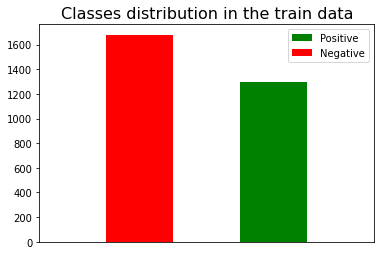

In [4]:
plt.hist(train_df[train_df.label == 1].label,
         bins=2, color='green', label='Positive')
plt.hist(train_df[train_df.label == 0].label,
         bins=2, color='red', label='Negative')
plt.title('Classes distribution in the train data', fontsize=16)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [5]:
print(train_df.isnull().sum())

text      0
aspect    0
label     0
dtype: int64


In [6]:
def tokens(words):
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                 
    return " ".join(text)  

In [7]:
train_df["clear_text"] = train_df['text'].apply(tokens)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,can you check whether its cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely on both milk delivery and grocery ...
2,"I get no notification, however the app is real...",notification,0,i get no notification however the app is reall...
3,"Love this app, but would love it even more if ...",view,1,love this app but would love it even more if g...
4,it does not let me load a clip on the scene,load,0,it does not let me load a clip on the scene


In [8]:
stop_words = stopwords.words('english')
def stopwords(review):
    text = [word.lower() for word in review.split() if word.lower() not in stop_words]
    return " ".join(text)

In [9]:
train_df['clear_text'] = train_df['clear_text'].apply(stopwords)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery items
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt charts calendar...
4,it does not let me load a clip on the scene,load,0,let load clip scene


In [10]:
# The next step is the normalization of words in the corpus by transform all of different forms of the word into one. 
# The two methods that exist for this purpose are Stemming and Lemmatization. We used the Lemmatization one.
lem = WordNetLemmatizer()

def lemma(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

In [11]:
train_df['clear_text'] = train_df['clear_text'].apply(lemma)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
4,it does not let me load a clip on the scene,load,0,let load clip scene


# Approach 1: using ml algorithms { Test Accuracy: 66.3% }

In [14]:
positive = train_df[train_df.label== 1]
negative = train_df[train_df.label== 0]
positive.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
6,unlimited yearly at $216/year,yearly,1,unlimited yearly year
8,Would love the ability to “un-delete” deleted ...,tasks,1,would love ability un delete deleted task app ...
11,-&gt; i want to learn for the future whether w...,learn,1,gt want learn future whether team something wr...


In [15]:
negative.head()

,text,aspect,label,clear_text
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
4,it does not let me load a clip on the scene,load,0,let load clip scene
7,"some times missing to deliver, some times diff...","deliver,",0,time missing deliver time different order deli...
10,so i wanted to download the app.,app,0,wanted download app


In [16]:
positive_words =[]

for review in positive.clear_text:
    positive_words.append(review) 
positive_words = ' '.join(positive_words)
positive_words[:48]

'check whether cancelled completely love app woul'

In [23]:
negative_words = []

for review in negative.clear_text:
    negative_words.append(review)
negative_words = ' '.join(negative_words)
negative_words[:45]

'cannot rely milk delivery grocery item get no'

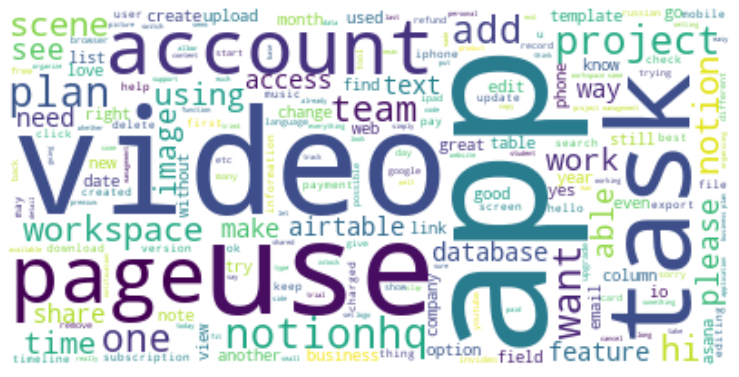

In [19]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

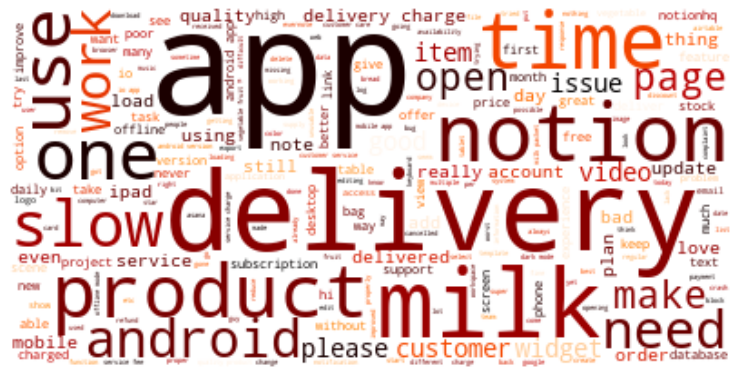

In [20]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words), colormap='gist_heat')

wordcloud.generate(negative_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [26]:
X = train_df['clear_text']
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [27]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)

len(vect.get_feature_names())

1095

## Logistic Regression: 66.3%

In [30]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train, )

ytest = np.array(y_test)
predictions = model.predict(vect.transform(X_test))

In [29]:
print('accuracy %s' % accuracy_score(predictions, y_test))
print(classification_report(ytest, predictions))

accuracy 0.66375
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       345
           1       0.68      0.66      0.67       267
           2       0.58      0.59      0.59       188

    accuracy                           0.66       800
   macro avg       0.65      0.65      0.65       800
weighted avg       0.66      0.66      0.66       800



In [32]:
from sklearn.ensemble import RandomForestClassifier
model_rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('clf-rf', RandomForestClassifier(n_estimators=50)),
                    ])

model_rf.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_rf.predict(X_test)

In [33]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.65875
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       345
           1       0.66      0.69      0.67       267
           2       0.59      0.52      0.55       188

    accuracy                           0.66       800
   macro avg       0.65      0.64      0.64       800
weighted avg       0.66      0.66      0.66       800



# Approach 2: RNN Classifier